In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

In [3]:
df = pd.read_excel('C:/Users/HP/Desktop/Pesate2022finoanovembre.xlsx', sheet_name='ORDINATI PER PESO', header=2)

In [4]:
df.drop(679, axis = 0, inplace=True)

# ANALISI ABC EURO MASTER
## INDIVIDUAZIONE CODICI AD ALTA ROTAZIONE

La tecnica ABC si basa sul teorema di Pareto, detto anche Legge 80/20.
Secondo tale teorema, la maggior parte degli effetti dipende da un numero limitato di cause (approssimando, risulta che l’80% degli effetti dipende dal 20% delle cause). 
Tale analisi permette di definire quali sono i codici su cui focalizzare l'attenzione. 

Nel nostro caso, l'analisi ABC è utile per individuare i codici ad alta rotazione e:
* dimensionare i buffer
* valutare quali codici tenere a buffer(fissi o rotanti)
* definire le migliori zone di allocazione all’interno del magazzino.

In [20]:
df.columns

Index(['Codice      ', '   Kg.Utilizzo', ' Num.Statini', ' Num.Mescole',
       'PesataMin.', 'PesataMax.', 'StatMin.', 'StatMax.', 'pareto_kg',
       'pareto_statini', 'pareto_mescole'],
      dtype='object')

In [25]:
mask = df[ df['Codice      '].str.contains('5E') ].index
df.drop(mask, inplace=True)

In [26]:
df

,Codice,Kg.Utilizzo,Num.Statini,Num.Mescole,PesataMin.,PesataMax.,StatMin.,StatMax.,pareto_kg,pareto_statini,pareto_mescole
0,ADD1,10085.7,492,21935,0,13.000,N2100043,N2101919,2355509.5,4734,21935
1,ADD11,10779.1,1114,16808,0.085,8.300,N2101887,N2100688,2335127.4,1114,38743
2,LDPE1,129476.5,949,15774,0.04,72.000,N2101239,N2101551,726590.5,3035,54517
3,ADD3,10296.4,187,14843,0,13.000,N2100043,N2101919,2345423.8,10053,69360
4,NERO14,43625.2,319,14239,0,25.000,N2100042,N2100237,1745706.7,7110,83599
...,...,...,...,...,...,...,...,...,...,...,...
670,OROPL2,3.4,1,1,3.45,3.450,N2101340,N2101340,2773742.6,16307,428298
672,ROSSOPL1,3.0,1,1,3,3.000,N2101340,N2101340,2773748.6,16309,428300
673,ADD256,0.3,1,1,0.338,0.338,N2100188,N2100188,2773770.0,16311,428301
675,PC1,9.1,1,1,9.147,9.147,N2100333,N2100333,2773481.5,16344,428303


Dal file fornito prendiamo in considerazione tre colonne:
* Codice
* Kg.Utilizzo --> rappresenta il totale di Kg di quel codice utilizzati nel 2021
* Num.Mescole --> rappresenta il totale di mescole contenenti quel codice fatte nel 2021

In [27]:
df['pareto_kg'] = 0
df['pareto_statini'] = 0 
df['pareto_mescole'] = 0

In [28]:
def calcola_pareto(df, col1, col2):
    df.sort_values(col1, inplace=True, ascending=False)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    for i in df.index:
        if i == 0:
            df.loc[i, col2] = df.loc[i, col1]
        else:
            df.loc[i, col2] = df.loc[i - 1, col2] + df.loc[i, col1]
    return(df)

In [29]:
for col_a, col_b in {'   Kg.Utilizzo' : 'pareto_kg', ' Num.Statini' : 'pareto_statini', ' Num.Mescole' : 'pareto_mescole'}.items():
    df = calcola_pareto(df, col_a, col_b)

In [30]:
df

,Codice,Kg.Utilizzo,Num.Statini,Num.Mescole,PesataMin.,PesataMax.,StatMin.,StatMax.,pareto_kg,pareto_statini,pareto_mescole
0,ADD1,10085.7,492,21935,0,13.00,N2100043,N2101919,2355509.5,4734,21935
1,ADD11,10779.1,1114,16808,0.085,8.30,N2101887,N2100688,2335127.4,1114,38743
2,LDPE1,129476.5,949,15774,0.04,72.00,N2101239,N2101551,726590.5,3035,54517
3,ADD3,10296.4,187,14843,0,13.00,N2100043,N2101919,2345423.8,10053,69360
4,NERO14,43625.2,319,14239,0,25.00,N2100042,N2100237,1745706.7,7110,83599
...,...,...,...,...,...,...,...,...,...,...,...
446,OROPL2,3.4,1,1,3.45,3.45,N2101340,N2101340,2741655.3,15975,422706
447,ROSSOPL1,3.0,1,1,3,3.00,N2101340,N2101340,2741658.3,15974,422707
448,GIALLO72,0.5,1,1,0.54,0.54,N2100029,N2100029,2741681.7,15969,422708
449,5D3-3012,23.0,1,1,23,23.00,N2101307,N2101307,2740187.4,16014,422709


In [31]:
#Lista dei codici in percentuale ==  asse x del grafico
codici = []

for x in range( len( df ) ):
    codici.append( ( x / len(df) ) * 100 )

In [32]:
def plotting(pareto_column, y_titolo, plot_titolo):
    global df
    df.sort_values(pareto_column, inplace = True)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    asse_y = []
    massimo = df[pareto_column].max()
    for x in df[pareto_column]:
        y = x/massimo * 100
        asse_y.append(y)

    plt.figure( figsize = ( 12, 6 ), dpi = 200 )
    plt.plot( codici, asse_y, color='black')

    plt.xticks(np.arange(0, 100, 5))
    plt.yticks(np.arange(0, 100, 5))
    plt.axvspan(0, 10, alpha=0.3, color='red')
    plt.axvspan(10, 25, alpha=0.3, color='yellow')
    plt.axvspan(25, 100, alpha=0.3, color='green')

    plt.xlabel('Percentuale sul totale dei codici')
    plt.ylabel(y_titolo)
    plt.title(plot_titolo)
    return()

#### Dopo aver ordinato i codici secondo valori decrescenti di Kg consumati (primo grafico) e mescole fatte (secondo grafico). Si può ricavare la curva cumulata che rappresenta la frazione Y di consumi/movimentazioni rispetto al totale (asse ordinate), prodotta complessivamente dai codici che rappresentano la frazione X (asse ascisse) del totale di codici usati nel 2021.

Classifichiamo i codici in tre classi:
* Classe A codici evidenziati in rosso
* Classe B codici evidenziati in giallo
* Classe C codici evidenziati in verde

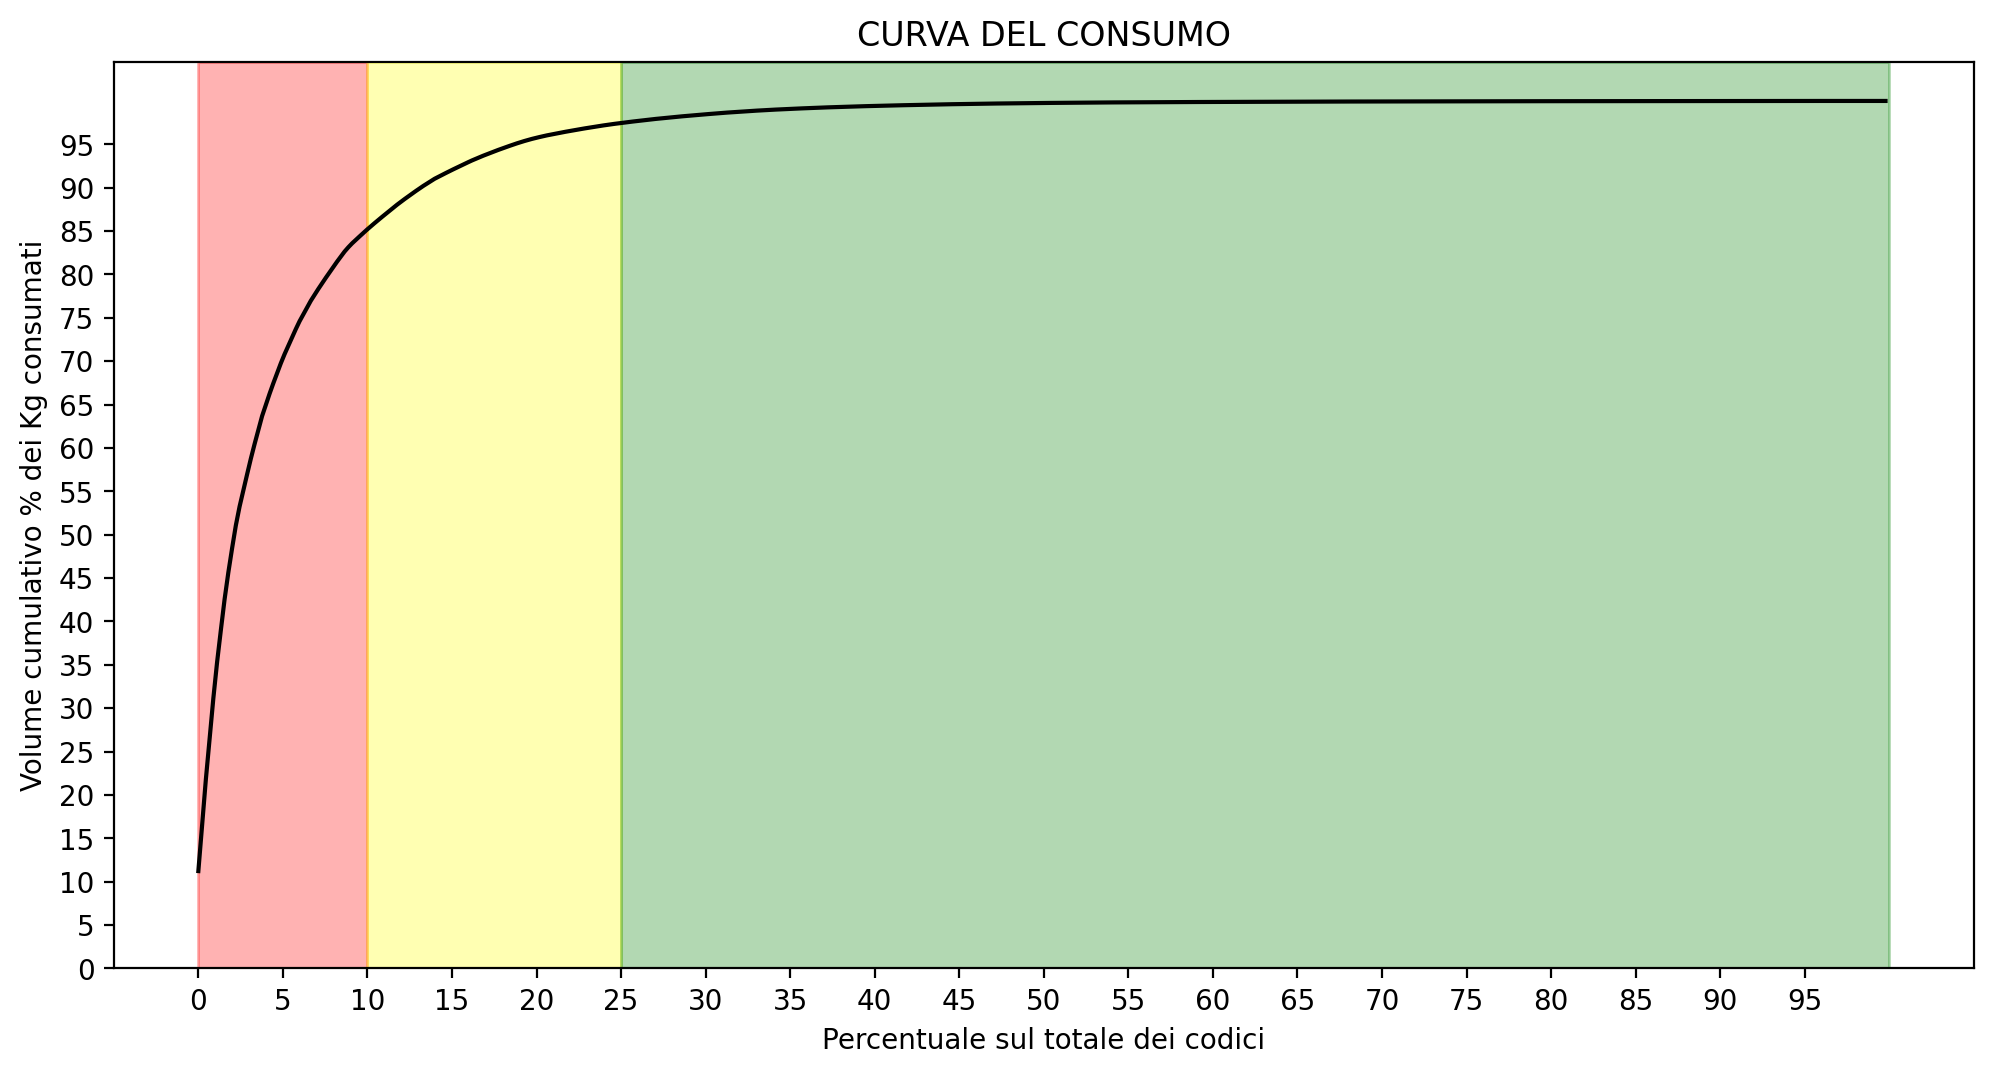

In [33]:
plotting('pareto_kg', 'Volume cumulativo % dei Kg consumati', 'CURVA DEL CONSUMO')
plt.savefig('C:/Users/HP/Desktop/paretostorico.png')

In [34]:
#CODICI NEL 10% KG
idx = math.floor(len(df)*0.1)
codici_kg = list(df['Codice      '][0 : idx])

tmp = []
for x in codici_kg:
    y = x.strip(' ')
    tmp.append(y)
codici_kg = tmp

()

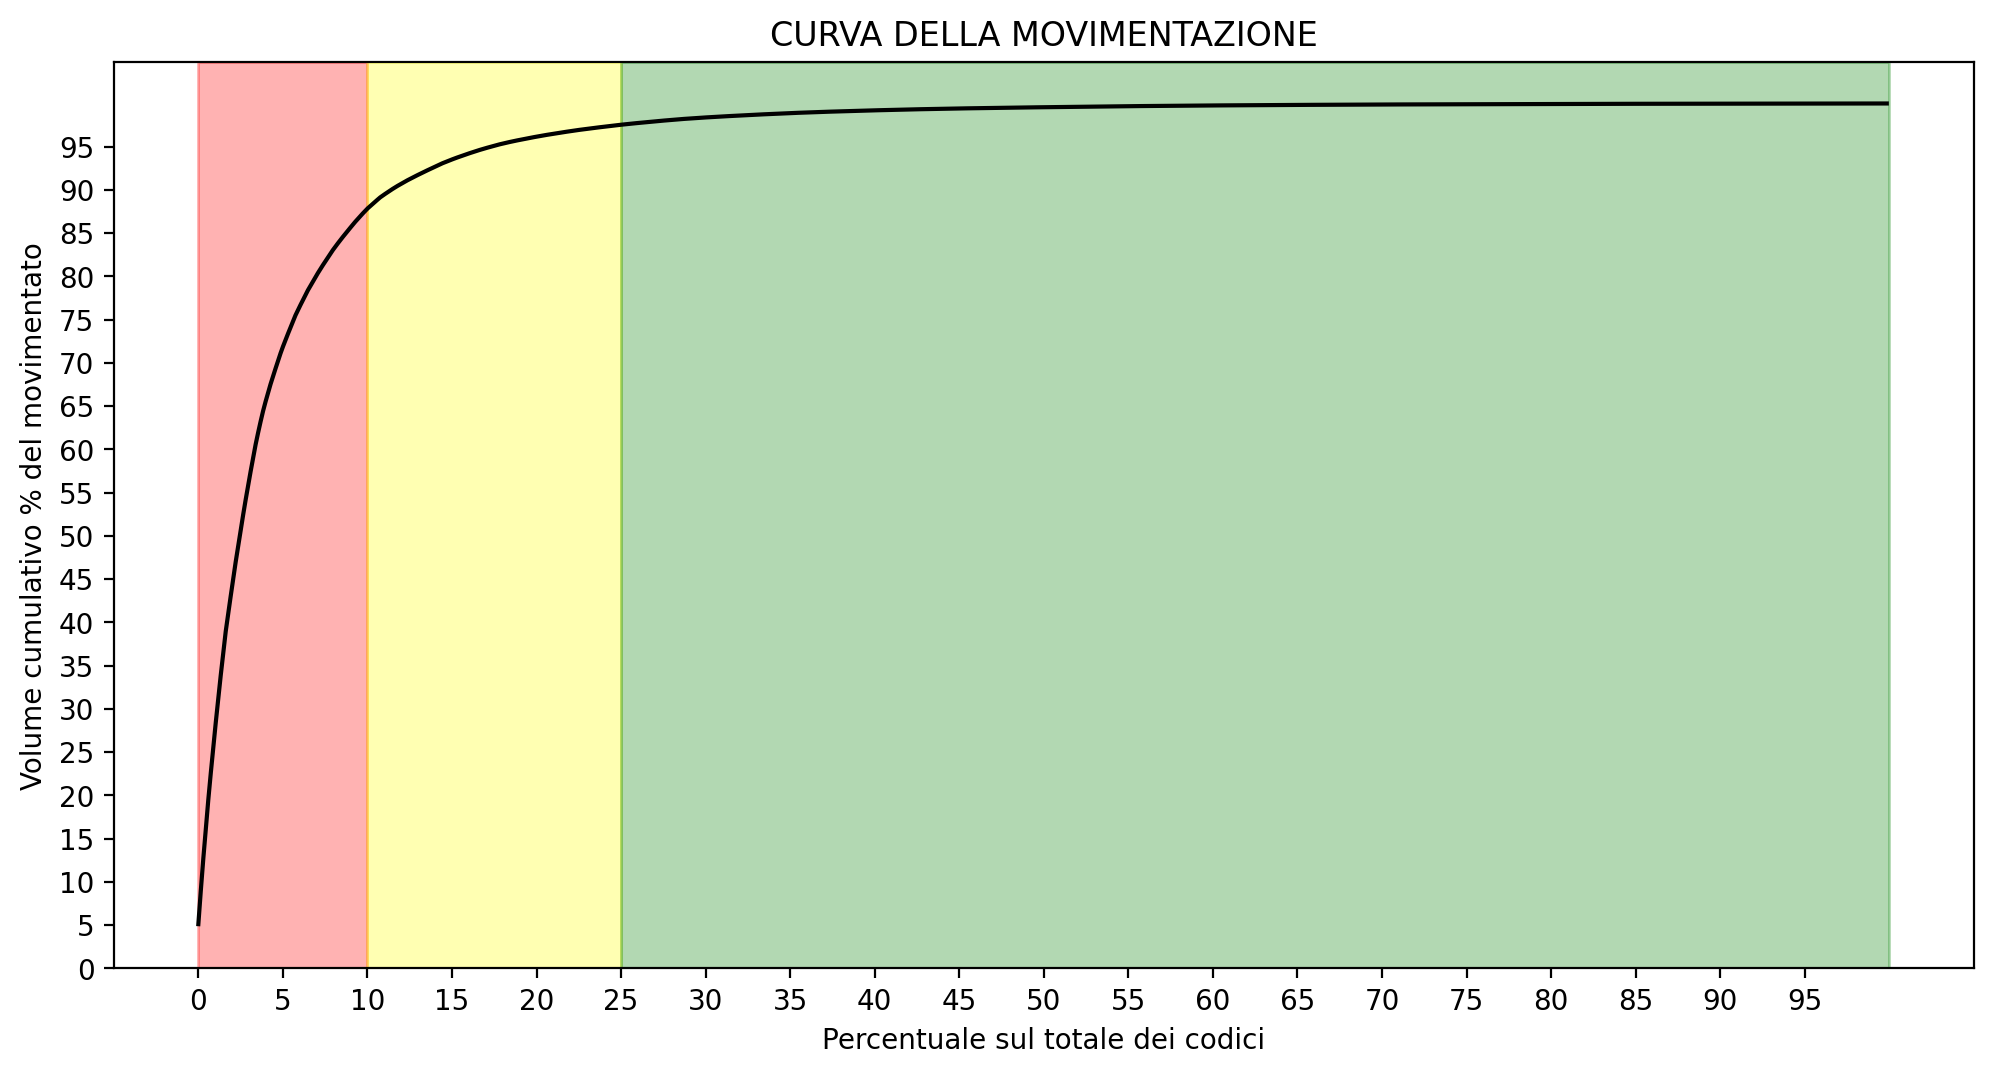

In [14]:
plotting('pareto_mescole', 'Volume cumulativo % del movimentato', 'CURVA DELLA MOVIMENTAZIONE')

In [15]:
#CODICI NEL 10% DELLE MESCOLE
idx = math.floor(len(df)*0.1)
codici_mescole = list(df['Codice      '][0 : idx])

tmp = []
for x in codici_mescole:
    y = x.strip(' ')
    tmp.append(y)
codici_mescole = tmp

Rispetto al classico pareto che prevede un rapporto 80/20 tra asse delle ordinate e asse delle ascisse, qui abbiamo un distacco ancora più evidente.

### Curva del consumo
Il 10% del totale dei codici rappresenta il 90% dei Kg di prodotto consumati, questi codici di classe A saranno quelli ai quali prestare più attenzione, non si può rischiare di andare stockout su questi codici.

### Curva della rotazione
Qui il 10% dei codici rappresenta l'85% del movimentato, questi codici dovranno essere piazzati nel buffer o in zone del magazzino facilmente accessibili.

In [16]:
codici_mescole_as_set = set(codici_mescole)
intersection = codici_mescole_as_set.intersection(codici_kg)

In [17]:
%pprint

Pretty printing has been turned OFF


In [18]:
codici_kg

['PL1', 'BIANCO22', 'FILLER5', 'LDPE1', 'FILLER3', 'LDPE3', 'LDPE7', 'LLDPE1', 'LDPE8', 'PPH3', 'LLDPE5', 'LDPE2', 'BIANCO35', 'PLARPO', 'BIANCO4', 'BIANCO8', 'PL8', 'NERO14', 'PPH2', 'CMM', 'LDPE4', 'PL1P', 'FILLER6', 'ABS6', 'ADD61', 'PPR2', 'LLDPE6', 'ABS6A', 'ADD144', 'PPC3', 'LDPE8A', 'BIANCO20', 'BIO-5003', 'BIANCO15', 'ROSSO9', 'LLDPE2', 'ADD70', 'FILLER12', 'BIANCO2', 'ADD24', 'HDPE1', 'EVA8', 'GIALLO17', 'ADD187', 'ADD8', 'ADD11', 'ADD3', 'ADD1', 'LDPE11', 'NERO29', 'ADD67', 'LDPE41', 'LDPE5', 'EVA1', 'BLU3', 'ADD72', 'SAN1', 'LDPE32', '5DB-2613A', 'LITHO1', 'PLA5', 'GIALLO84', 'BIO-5020A', 'BIANCO38', 'ADD18', 'ROSSO29', 'BIO-CHIPS']

Qui si vedono quali sono i codici di CLASSE A per quanto riguarda il consumo.

In [ ]:
codici_mescole

Qui si vedono quali sono i codici di CLASSE A per quanto riguarda la movimentazione.

In [ ]:
list(intersection)

### Facendo un intersezione tra le due liste di codici appena viste, troviamo i codici che sono in classe A sia dal punto di vista del consumo che della rotazione. Per essere abbastanza sicuri delle prestazioni il buffer dovrebbe essere dimensionato in modo tale da contenere una buona parte di questa lista di codici.

L'analisi poi si potrebbe dettagliare con calma pià avanti utilizzando l'indice di accesso al magazzino, visto che vogliono fare anche un magazzino automatico fuori.